In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class TransformationMatrix:
    
    def __init__(self, alpha, a, d, theta):
        self.alpha = alpha
        self.a = a
        self.d = d
        self.theta = theta
        self.update_matrix()
        self.update_derivative()
        
        
    def update_matrix(self):
        self.matrix = np.array(
            [
                [np.cos(self.theta),
                 -np.sin(self.theta),
                 0,
                 self.a],
                
                [np.sin(self.theta)*np.cos(self.alpha),
                 np.cos(self.theta)*np.cos(self.alpha),
                 -np.sin(self.alpha),
                 -np.sin(self.alpha)*self.d],
                
                [np.sin(self.theta)*np.sin(self.alpha),
                 np.cos(self.theta)*np.sin(self.alpha),
                 np.cos(self.alpha),
                 np.cos(self.alpha)*self.d],
                
                [0,
                 0,
                 0,
                 1]
            ]
        )
        
    def update_derivative(self):
        self.dmatrix_dtheta = np.array(
            [
                [-np.sin(self.theta),
                 -np.cos(self.theta),
                 0,
                 0],
                
                [np.cos(self.theta)*np.cos(self.alpha),
                 -np.sin(self.theta)*np.cos(self.alpha),
                 0,
                 0],
                
                [np.cos(self.theta)*np.sin(self.alpha),
                 -np.sin(self.theta)*np.sin(self.alpha),
                 0,
                 0],
                
                [0,
                 0,
                 0,
                 0]
            ]
        )
    
    def __repr__(self):
        return str(self.matrix.round(8))
    
    
    
class ModelForward:
    
    def __init__(self, dh_table, M_start, M_end):
        self.Tmatrices = [TransformationMatrix(*param_line) for param_line in dh_table]
        self.M_end = M_end
        self.M_start = M_start
        
    def update_dh_table(self, dh_table):
        self.Tmatrices = [TransformationMatrix(*param) for param in dh_table]
        
    def compute_forward(self):
        config = []
        x = np.identity(4)
        x = x @ self.M_start
        config.append(x)
        for i,M in enumerate(self.Tmatrices):
            x = x @ M.matrix
            config.append(x)
        x = x @ self.M_end
        config.append(x)
        return x, np.stack(config)
    
    def compute_jacobian(self):
        dtheta = []
        for i in range(len(self.Tmatrices)):
            x = np.identity(4)
            x = x @ self.M_start
            for j, M in enumerate(self.Tmatrices):
                if i == j:
                    x = x @ M.dmatrix_dtheta
                else:
                    x = x @ M.matrix
            x = x @ self.M_end
            dtheta.append(x)
        jacobian = np.zeros((3, len(dtheta)))
        for i,dtheta_i in enumerate(dtheta):
            jacobian[:, i] = dtheta_i[:3, 3]
        
        return jacobian, np.stack(dtheta)
    


# Robotic arm with 3 revolute joints
### Forward model

In [3]:
# Fist we model a simple robotic arm with 3 revolute joints in the same plane.

# We set DH parameters of the robot:
def get_dh_simple_arm(q, l1=1, l2=1):
    q = q.flatten()
    s0 = [0, 0, 0, q[0]]
    s1 = [0, l1, 0, q[1]]
    s2 = [0, l2, 0, q[2]]
    return np.array([s0,s1,s2])

# Initial parameters (angular positions of the revolute joints)
theta0 = np.pi/3
theta1 = -3*np.pi/7
theta2 = +np.pi/3
q_current = np.array([theta0, theta1, theta2]).reshape((-1, 1))


# Position of the first joint in the world frame, and the end effector in the last frame
x_end = np.array([1, 0, 0, 1]).reshape(-1,1)
M_end = np.concatenate((np.eye(4,3), x_end), axis=1)
x_start = np.array([0, 1, 0, 1]).reshape(-1,1)
M_start = np.concatenate((np.eye(4,3), x_start), axis=1)

dh_table = get_dh_simple_arm(q_current)
model_robot1 = ModelForward(dh_table, M_start, M_end)

# We compute the position of the end effector and the joints
x_end_effector, config = model_robot1.compute_forward()

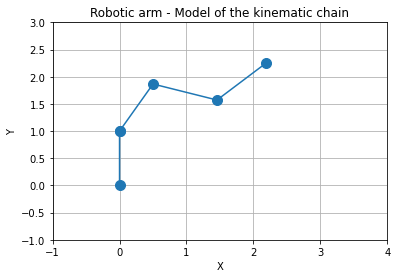

In [4]:
# We draw the robot (kinematic chain)
# The first dot at position (0, 0) is the base of the robot
# The next 3 dots in the chain are the joints
# The last dot around position (2.1, 2.2) is the end effector
# The lines represent links

%matplotlib inline
arm_pos = [[0, 0, 0]]
for pos in config:
    arm_pos.append([pos[0,-1], pos[1,-1], pos[2,-1]])
arm_pos = np.array(arm_pos)
plt.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robotic arm - Model of the kinematic chain')
plt.xlim(-1,4)
plt.ylim(-1,3)
plt.grid()

We model a robotic arm with 3 revolute joints. <br>
We set the initial angular positions of the joints to
$q = (\theta_1, \theta_2, \theta_3) = ({\pi \over{3}}, -{3\pi \over{7}}, {\pi \over{3}})$. <br>
Then we compute the forward model to have the positions of the joints and the end effector in space (X, Y, Z). <br>
We draw the projection of the kinematic chain in the (X, Y) basis. <br>
(In this case there is no point in representing the Z position since all the joints of the robot are in the same plane othogonal to the Z axis.)

- The first dot at position (0, 0) is the base of the robot. <br>
- The next 3 dots in the chain are the 3 joints. <br>
- The last dot around position (2.2, 2.3) is the end effector. <br>
- The lines represent the links between the joints.

This is the initial configuration of the robotic arm.  <br>
Next we try to reach a point at coordinate (X,Y) = (2, 0) with the end effector.
### Compute the ik via the inverse Jacobian method

**Important note:**
We only compute the Jacobian w.r.t. X,Y and Z (and not the angles because too complicated)

In [5]:
def get_path(q0, x_target, model, get_dh, Kp=0.1):
    q_current = q0.copy()
    q_path = [q_current]
    model.update_dh_table(get_dh(q_current))
    x, config = model.compute_forward()
    config_path = [config]
    for i in range(15):
        x_current = x[0:3, 3].reshape((-1, 1))
        x_error = x_target - x_current
        q_next = q_current + Kp * np.linalg.pinv(model.compute_jacobian()[0]) @ x_error
        q_current = q_next.copy()
        q_path.append(q_current)
        model.update_dh_table(get_dh(q_current))
        x, config = model.compute_forward()
        config_path.append(config)
        Kp = min((1, 1.1*Kp))
    return np.stack(q_path), config_path


# Initial configuration of the joints:
q0 = np.array([theta0, theta1, theta2]).reshape((-1, 1))

# Target position for the end effector:
x_target = np.array([2, 0, 0]).reshape((-1, 1))

# We compute the path with the inverse Jacobian method:
q_path, config_path = get_path(q0, x_target, model_robot1, get_dh_simple_arm, Kp=0.1)

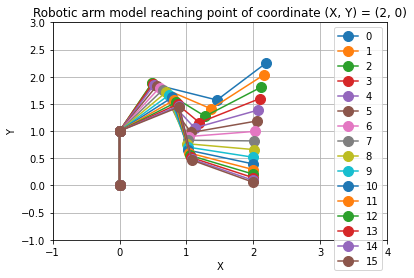

In [6]:
for i, config in enumerate(config_path):
    arm_pos = [[0, 0]]
    for pos in config:
        arm_pos.append([pos[0,-1], pos[1,-1]])
    arm_pos = np.array(arm_pos)
    plt.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20, label=i)
    plt.xlim(-1,4)
    plt.ylim(-1,3)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robotic arm model reaching point of coordinate (X, Y) = (2, 0)')
plt.legend()
plt.grid()

The robot moves the end effector, which is initially around position $(x_0,y_0) = (2.2, 2.3)$ to the target position $(x_t,y_t) = (2, 0)$. <br>
Each color represents the position of the robotic arm at one point in time. <br>
We can see that the robot progressively moves from the initial (blue with label 0) position, to the final (brown with label 15) position where the end effector reaches the desired position.

**Important note:**
We only compute the Jacobian w.r.t. X,Y and Z (and not the angles because too complicated)

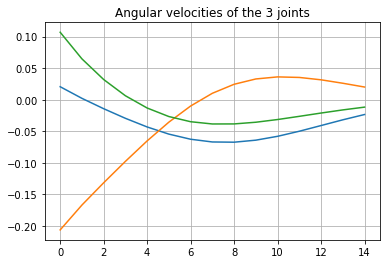

In [7]:
dt = 1
v = (q_path[1:] - q_path[:-1]) / dt
plt.plot(np.concatenate(v, axis=1).T)
plt.title("Angular velocities of the 3 joints")
plt.grid()

# Franka-Emilka panda
### Forward model
cf. https://frankaemika.github.io/docs/control_parameters.html#denavithartenberg-parameters

In [8]:
theta = np.array([0., 0., 0., 0.0, 0., 0., 0.])


def get_FE_dh(q):
    theta = q.flatten()
    dh_table = np.array(
        [[0, .333, 0, theta[0]],
         [0, 0, -np.pi/2, theta[1]],
         [0, 0.316, np.pi/2, theta[2]],
         [.0825, 0, np.pi/2, theta[3]],
         [-.0825, 0.384, -np.pi/2, theta[4]],
         [0, 0, np.pi/2, theta[5]],
         [.088, 0, np.pi/2, theta[6]]])
    dh_table = dh_table[:, [2, 0, 1, 3]]
    return dh_table

dh_table = get_FE_dh(theta)
x_start = np.array([0, 0, 0, 1]).reshape(-1,1)
M_start = np.concatenate((np.eye(4,3), x_start), axis=1)
x_end = np.array([0, 0, 0.107, 1]).reshape(-1,1)
M_end = np.concatenate((np.eye(4,3), x_end), axis=1)


model_FE = ModelForward(dh_table, M_start, M_end)
x_end_effector, config = model_FE.compute_forward()

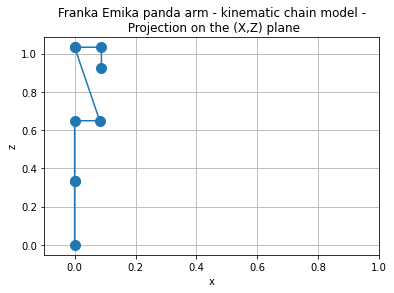

In [9]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes()

arm_pos = []
for pos in config:
    arm_pos.append([pos[0,3], pos[2,3]])

arm_pos = np.array(arm_pos)
ax.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title('Franka Emika panda arm - kinematic chain model -\n Projection on the (X,Z) plane (view from the side)')
plt.xlim(-0.1, 1)
plt.grid()

This is the initial configuration of the robotic arm (when all the joint angles are at position 0 rad). <br>
Note that the basis of projection (X,Z) is not normalized.<br>
Next we try to reach a point at coordinate (X,Y) = (2, 0) 


### Inverse kinematics via Jacobian
We only compute the Jacobian w.r.t. X,Y and Z (and not the angles because too complicated)

In [10]:
def get_path(q0, x_target, model, get_dh, Kp=0.05):
    q_current = q0.copy()
    q_path = [q_current]
    model.update_dh_table(get_dh(q_current))
    x, config = model.compute_forward()
    config_path = [config]
    x_current = x[0:3, 3].reshape((-1, 1))
    x_error = x_target - x_current
    dist = [np.linalg.norm(x_error)]
    Kp_values = [Kp]
    itr = 0
    while np.linalg.norm(x_error) > 0.001:
        itr += 1
        if itr > 100:
            break
        q_next = q_current + Kp * np.linalg.pinv(model.compute_jacobian()[0]) @ x_error
        q_current = q_next.copy()
        q_path.append(q_current)
        model.update_dh_table(get_dh(q_current))
        x, config = model.compute_forward()
        config_path.append(config)
        x_current = x[0:3, 3].reshape((-1, 1))
        x_error = x_target - x_current
        dist.append(np.linalg.norm(x_error))
        Kp = min((1, 1.1*Kp))
        Kp_values.append(Kp)
    return np.stack(q_path), config_path, np.array(dist), np.array(Kp_values)

# Initial angular positions of the 7 joints
q0 = np.zeros(7).reshape((-1, 1))

# Target position: Point of coordinate (X, Y, Z) = (0.6, 0.3, 0.1)
x_target = np.array([0.6, 0.3, 0.1]).reshape((-1, 1))

# Compute the path via the inverse Jacobian method
q_path, config_path, dist, kp_values = get_path(q0, x_target, model_FE, get_FE_dh)

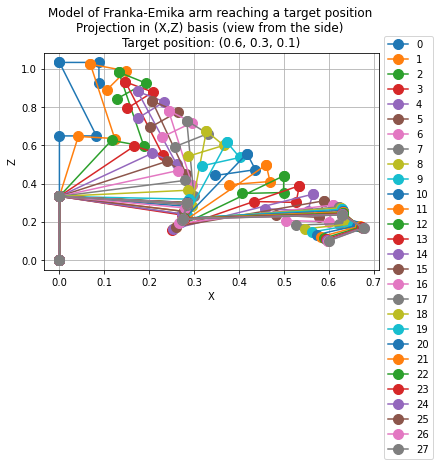

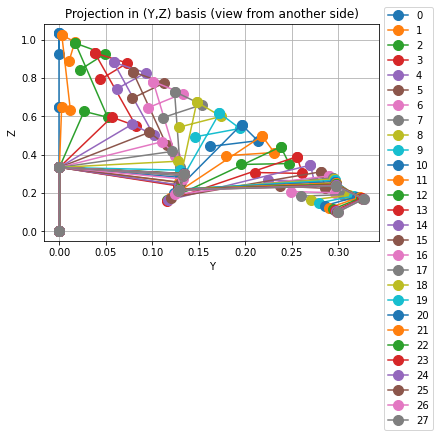

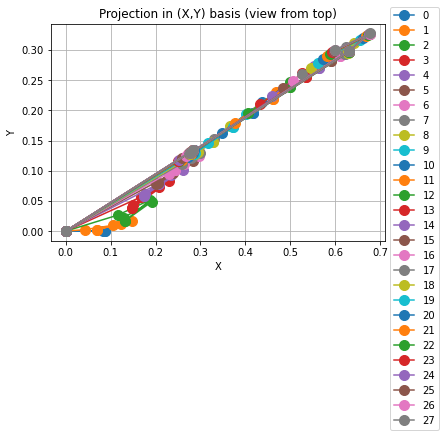

In [23]:
%matplotlib inline
plt.figure()
for i, config in enumerate(config_path):
    arm_pos = [[0, 0]]
    for pos in config:
        arm_pos.append([pos[0,3], pos[2,3]])

    arm_pos = np.array(arm_pos)
    plt.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20, label=i)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Model of Franka-Emika arm reaching a target position \nProjection in (X,Z) basis (view from the side) \nTarget position: (0.6, 0.3, 0.1)')
plt.legend(bbox_to_anchor=(1, 1.1))
plt.grid()

plt.figure()
for i, config in enumerate(config_path):
    arm_pos = [[0, 0]]
    for pos in config:
        arm_pos.append([pos[1,3], pos[2,3]])

    arm_pos = np.array(arm_pos)
    plt.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20, label=i)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Projection in (Y,Z) basis (view from another side)')
plt.legend(bbox_to_anchor=(1, 1.1))
plt.grid()

plt.figure()
for i, config in enumerate(config_path):
    arm_pos = [[0, 0]]
    for pos in config:
        arm_pos.append([pos[0,3], pos[1,3]])

    arm_pos = np.array(arm_pos)
    plt.plot(arm_pos[:, 0], arm_pos[:, 1], '.-', markersize=20, label=i)
plt.title('Projection in (X,Y) basis (view from top)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(bbox_to_anchor=(1, 1.1))
plt.grid()

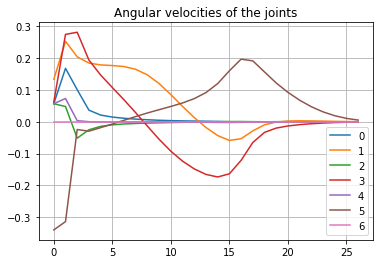

In [22]:
dt = 1
v = (q_path[1:] - q_path[:-1]) / dt
plt.plot(np.concatenate(v, axis=1).T)
plt.legend(range(7))
plt.title('Angular velocities of the joints')
plt.grid()

Text(0.5, 0, 'z')

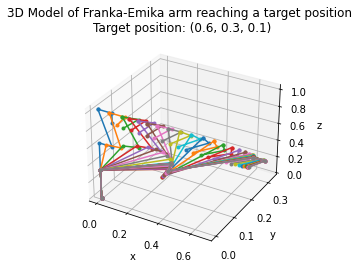

In [20]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")

for i, config in enumerate(config_path):
    arm_pos = [[0, 0, 0]]
    for pos in config:
        arm_pos.append([pos[0,3], pos[1,3], pos[2,3]])
    arm_pos = np.array(arm_pos).T
    ax.plot3D(arm_pos[0], arm_pos[1], arm_pos[2], '.-')
    
plt.title('3D Model of Franka-Emika arm reaching a target position \nTarget position: (0.6, 0.3, 0.1)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')